## Pfam seed random split

In [1]:
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

tf.test.is_built_with_cuda()

Tensorflow version 2.2.0


True

In [2]:
tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [3]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn
import gc
import sklearn
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [5]:
data_partitions_dirpath = './random_split'
print('Available dataset partitions: ', os.listdir(data_partitions_dirpath))

Available dataset partitions:  ['dev', 'model.h5', 'model.json', 'random_split', 'test', 'train']


## Loading the data

In [6]:
def read_all_shards(partition='dev', data_dir=data_partitions_dirpath):
    shards = []
    for fn in os.listdir(os.path.join(data_dir, partition)):
        with open(os.path.join(data_dir, partition, fn)) as f:
            shards.append(pd.read_csv(f, index_col=None))
    return pd.concat(shards)

test = read_all_shards('test')
dev = read_all_shards('dev')
train = read_all_shards('train')

partitions = {'test': test, 'dev': dev, 'train': train}
for name, df in partitions.items():
    print('Dataset partition "%s" has %d sequences' % (name, len(df)))

Dataset partition "test" has 126171 sequences
Dataset partition "dev" has 126171 sequences
Dataset partition "train" has 1086741 sequences


In [7]:
#Reduce

# train = train[:108674]
# dev = dev[:12617]
# test = test[:12617]

In [8]:
train.reset_index(inplace=True)
dev.reset_index(inplace=True)
test.reset_index(inplace=True)

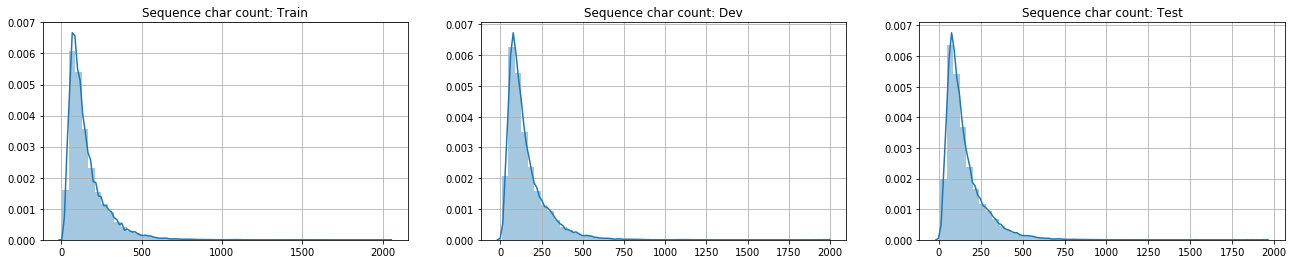

In [9]:
# Length of sequence in train data.
train['seq_char_count']= train['sequence'].apply(lambda x: len(x))
dev['seq_char_count']= dev['sequence'].apply(lambda x: len(x))
test['seq_char_count']= test['sequence'].apply(lambda x: len(x))

def plot_seq_count(df, data_name):
  seaborn.distplot(df['seq_char_count'].values)
  plt.title(f'Sequence char count: {data_name}')
  plt.grid(True)

plt.subplot(1, 3, 1)
plot_seq_count(train, 'Train')

plt.subplot(1, 3, 2)
plot_seq_count(dev, 'Dev')

plt.subplot(1, 3, 3)
plot_seq_count(test, 'Test')

plt.subplots_adjust(right=3.0)
plt.show()

In [10]:
def split_(word): 
    return [char for char in word]

train_sentences = train['sequence'].apply(lambda x: split_(x))
validation_sentences = dev['sequence'].apply(lambda x: split_(x))
test_sentences = test['sequence'].apply(lambda x: split_(x))

In [11]:
train_labels = train['family_accession'].apply(lambda x: x.split('.')[0])
validation_labels = dev['family_accession'].apply(lambda x: x.split('.')[0])
test_labels = test['family_accession'].apply(lambda x: x.split('.')[0])

# mask = train_labels.isin(test_labels)
# train_sentences = train_sentences[mask]
# train_labels = train_labels[mask]
# mask = validation_labels.isin(test_labels)
# validation_sentences = validation_sentences[mask]
# validation_labels = validation_labels[mask]
# numclass = len(np.unique(test_labels))

In [12]:
classes = train_labels.value_counts()[:1000].index.tolist()
len(classes)

1000

In [13]:
del train
del test
del dev
gc.collect()

20

In [14]:
mask = train_labels.isin(classes)
train_sentences = train_sentences[mask]
train_labels = train_labels[mask]
mask = validation_labels.isin(classes)
validation_sentences = validation_sentences[mask]
validation_labels = validation_labels[mask]
mask = test_labels.isin(classes)
test_sentences = test_sentences[mask]
test_labels = test_labels[mask]

print('Data size after considering 1000 classes for each data split:')
print('Train size :', len(train_sentences))
print('Val size :', len(validation_sentences))
print('Test size :', len(test_sentences))
numclass = len(classes)

Data size after considering 1000 classes for each data split:
Train size : 439493
Val size : 54378
Test size : 54378


In [15]:
vocab_size = 21
max_length = 250
trunc_type = "post"
padding_type = "post"
oov_tok = "<OOV>"

tokenizer = Tokenizer(oov_token=oov_tok, num_words = vocab_size)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index
print(word_index)

train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type)
del train_sequences
del train_sentences
gc.collect()

{'<OOV>': 1, 'l': 2, 'a': 3, 'g': 4, 'v': 5, 'i': 6, 'e': 7, 's': 8, 'r': 9, 'd': 10, 't': 11, 'k': 12, 'p': 13, 'f': 14, 'n': 15, 'q': 16, 'y': 17, 'm': 18, 'h': 19, 'c': 20, 'w': 21, 'x': 22, 'u': 23, 'b': 24, 'o': 25}


0

In [16]:
validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type)
del validation_sentences
del validation_sequences
gc.collect()

0

In [17]:
test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type)
del test_sentences
del test_sequences
gc.collect()

0

In [18]:
# takes too much space
# solved with non-trainable Embedding layer with identity initializer

# train_padded = tf.keras.utils.to_categorical(train_padded, num_classes=vocab_size)
# validation_padded = tf.keras.utils.to_categorical(validation_padded, num_classes=vocab_size)
# test_padded = tf.keras.utils.to_categorical(test_padded, num_classes=vocab_size)

In [19]:
train_padded.shape

(439493, 250)

In [20]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

train_labels = le.fit_transform(train_labels)
validation_labels = le.transform(validation_labels)
test_labels = le.transform(test_labels)

train_labels.shape, validation_labels.shape, test_labels.shape

((439493,), (54378,), (54378,))

In [21]:
max(train_labels)

999

In [22]:
max(validation_labels)

999

In [23]:
def residual_block(x, filters, dil):
    shortcut = x
    bn1 = tf.keras.layers.BatchNormalization()(x)
    a1 = tf.keras.layers.Activation("relu")(bn1)
    conv1 = tf.keras.layers.Conv1D(filters, 3, dilation_rate = dil, padding="same")(a1) #1100 filters and 9 kernel size in ProtCNN
    
    bn2 = tf.keras.layers.BatchNormalization()(conv1)
    a2 = tf.keras.layers.Activation("relu")(bn2)
    conv2 = tf.keras.layers.Conv1D(filters, 1, padding="same")(a2)
    
    x = tf.keras.layers.Add()([conv2, shortcut])
    
    return x

In [24]:
# lr_schedule = tf.keras.callbacks.LearningRateScheduler(
#     lambda epoch: 1e-5 * 10**(epoch / 20))

es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', min_delta=0.05, patience=3)

In [25]:
input_x = tf.keras.layers.Input(shape=max_length)
x = tf.keras.layers.Embedding(vocab_size, vocab_size, embeddings_initializer=tf.keras.initializers.Identity(gain=1.0), trainable=False)(input_x)
x = tf.keras.layers.Conv1D(128, 3, padding="same")(x)
x = residual_block(x, 128, 1)
x = residual_block(x, 128, 2) #4 blocks of these in ProtCNN
x = tf.keras.layers.MaxPooling1D(max_length)(x)

x = tf.keras.layers.Flatten()(x)
out = tf.keras.layers.Dense(numclass, activation="softmax")(x) 

model = tf.keras.Model(inputs=input_x, outputs=out)
#optimizer = tf.keras.optimizers.Adam(lr=1e-5)

model.compile(loss='sparse_categorical_crossentropy',optimizer="adam",metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 250)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 250, 21)      441         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 250, 128)     8192        embedding[0][0]                  
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 250, 128)     512         conv1d[0][0]                     
______________________________________________________________________________________________

In [26]:
history = model.fit(train_padded, train_labels, epochs=10, validation_data=(validation_padded, validation_labels), verbose=2, callbacks=[es])

Epoch 1/10
13735/13735 - 104s - loss: 0.8598 - accuracy: 0.8194 - val_loss: 0.2829 - val_accuracy: 0.9269
Epoch 2/10
13735/13735 - 105s - loss: 0.2002 - accuracy: 0.9461 - val_loss: 0.1931 - val_accuracy: 0.9489
Epoch 3/10
13735/13735 - 105s - loss: 0.1382 - accuracy: 0.9619 - val_loss: 0.1663 - val_accuracy: 0.9573
Epoch 4/10
13735/13735 - 105s - loss: 0.1043 - accuracy: 0.9705 - val_loss: 0.1556 - val_accuracy: 0.9607


In [0]:
# serialize model to JSON
model_json = model.to_json()
with open(os.path.join(data_partitions_dirpath, "model.json"), "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(os.path.join(data_partitions_dirpath, "model.h5"))
print("Saved model to disk")

Saved model to disk
Loaded model from disk


In [6]:
# load json and create model
json_file = open(os.path.join(data_partitions_dirpath, "model.json"), 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = tf.keras.models.model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(os.path.join(data_partitions_dirpath, "model.h5"))
print("Loaded model from disk")
 
# calculate embedding for new data
embedder = tf.keras.Model(inputs = loaded_model.layers[0].input, outputs = loaded_model.layers[18].output)
# embedder.compile(loss='categorical_crossentropy',optimizer="adam")
# predict should be allowed to use w/o compilation: 
# https://github.com/keras-team/keras/issues/2621
# embeds = loaded_model.predict(test_padded[:10])

Loaded model from disk


In [41]:
#2ZTB
seq = "MDVIREYLMFNELSALSSSPESVRSRFSSIYGTNPDGIALNNETYFNAVKPPITAQYGYYCYKNVGTVQYVNRPTDINPNVILAQDTLTNNTNEPFTTTITITGSFTNTSTVTSSTTTGFKFTSKLSIKKVFEIGGEVSFSTTIGTSETTTETITVSKSVTVTVPAQSRRTIQLTAKIAKESADFSAPITVDGYFGANFPKRVGPGGHYFWFNPARDVLNTTSGTLRGTVTNVSSFDFQTIVQPARSLLDEQ"
arr = [[char for char in seq]]
seq_sequences = tokenizer.texts_to_sequences(arr)
seq_padded = pad_sequences(seq_sequences, maxlen=max_length, padding=padding_type)
seq_padded.shape

(1, 250)

In [0]:
def parse_fasta (lines):
    descs = []
    seqs = []
    data = ''
    for line in lines:
        if line.startswith('>'):
            if data:   # have collected a sequence, push to seqs
                seqs.append(data)
                data = ''
            descs.append(line[1:])  # Trim '>' from beginning
        else:
            data += line.rstrip('\r\n')
    # there will be yet one more to push when we run out
    seqs.append(data)
    return descs, seqs

descriptions, sequences = parse_fasta(open('/content/drive/My Drive/uniprot-insecticidal-filtered-reviewed_yes.fasta', 'r').read().split('\n'))

In [43]:
seqs = [split_(x) for x in sequences] 
seqs_sequences = tokenizer.texts_to_sequences(seqs)
seqs_padded = pad_sequences(seqs_sequences, maxlen=max_length, padding=padding_type)
seqs_padded.shape

(419, 250)

In [44]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances


embed_2ztb = loaded_model.predict(seq_padded)
embed_uniprots = loaded_model.predict(seqs_padded)
sim_cosine = cosine_similarity(embed_2ztb, embed_uniprots)
distances = euclidean_distances(embed_2ztb, embed_uniprots)

print("Query sequence was: ")
print(seq)

idx = np.argmax(sim_cosine)
print("Most cosine similar:")
print(descriptions[idx])
print(sequences[idx])

idx = np.argmin(distances)
print("Closest in the 128 dim space")
print(descriptions[idx])
print(sequences[idx])

Query sequence was: 
MDVIREYLMFNELSALSSSPESVRSRFSSIYGTNPDGIALNNETYFNAVKPPITAQYGYYCYKNVGTVQYVNRPTDINPNVILAQDTLTNNTNEPFTTTITITGSFTNTSTVTSSTTTGFKFTSKLSIKKVFEIGGEVSFSTTIGTSETTTETITVSKSVTVTVPAQSRRTIQLTAKIAKESADFSAPITVDGYFGANFPKRVGPGGHYFWFNPARDVLNTTSGTLRGTVTNVSSFDFQTIVQPARSLLDEQ
Most cosine similar:
sp|B6A879|CHI2_YERET Chitinase 2 OS=Yersinia entomophaga OX=935293 GN=chi2 PE=1 SV=1
MVNKYTYTSSKAMSDISDVIGEPLAAWDSQVGGRVFNVIFDGKVYTNTYWVERWQVPGIGSSDGNPHNAWKFVRAATADEINKIGNPTTADVKPTENIPSPILVEDKYTEETYSRPDVNFKEDGSQGNLSYTATRVCAPMYNHYVGDKTKPKLSAYITDWCQYDARLDGGGSKEEERGRGFDLATLMQNPATYDRLIFSFLGICGDIGNKSKKVQEVWDGWNAQAPSLGLPQIGKGHIVPLDPYGDLGTARNVGLPPESADTSIESGTFLPYYQQNRAAGLLGGLRELQKKAHAMGHKLDLAFSIGGWSLSSYFSALAENPDERRVFVASVVDFFVRFPMFSCVDIDWEYPGGGGDEGNISSDKDGENYVLLIKELRSALDSRFGYSNRKEISIACSGVKAKLKKSNIDQLVANGLDNIYLMSYDFFGTIWADYIGHHTNLYSPKDPGEQELFDLSAEAAIDYLHNELGIPMEKIHLGYANYGRSAVGGDLTTRQYTKNGPALGTMENGAPEFFDIVKNYMDAEHSLSMGKNGFVLMTDTNADADFLFSEAKGHFISLDTPRTVKQKGEYAAKNKLGGVFSWSGDQDCGLLANAAREGLGYVADSNQETIDMGPLYNPGK

In [40]:
np.max(sim_cosine)

0.22009304